In [1]:
JSON_PATHS = {
   'circle':"../results/bo_results_20250917_003320_single_modal_multi_modal_circular_community_circular.json",
   'single-modal':"../results/bo_results_20250917_003320_single_modal_multi_modal_circular_community_single_modal.json",
   'multi-modal':"../results/bo_results_20250917_015750_bimodal_circular_community_bimodal.json",
   'community':"../results/bo_results_20250917_015750_bimodal_circular_community_community.json",
   'enron':"../results/bo_results_20250915_042946_youtube_twitch_facebook_enron_enron.json",
   'facebook':"../results/bo_results_20250915_042946_youtube_twitch_facebook_enron_facebook.json",
   'twitch':"../results/bo_results_20250915_042946_youtube_twitch_facebook_enron_twitch.json",
   'youtube':"../results/bo_results_20250915_042946_youtube_twitch_facebook_enron_youtube.json",
   '500hpa': "../results/bo_results_20250912_114129_500hpa_wide_800hpa_wide_1000hpa_wide_500hpa_wide.json",
   '800hpa': "../results/bo_results_20250912_114129_500hpa_wide_800hpa_wide_1000hpa_wide_800hpa_wide.json",
   '1000hpa': "../results/bo_results_20250912_114129_500hpa_wide_800hpa_wide_1000hpa_wide_1000hpa_wide.json"
}

In [2]:
import json
import pandas as pd
import os

# Load all JSON files into dictionary of DataFrames
dataframes = {}
for dataset, path in JSON_PATHS.items():
    if os.path.exists(path):
        with open(path, 'r') as f:
            data = json.load(f)
        
        # Handle different JSON structures
        if 'summary_results' in data:
            # Aggregated data - use summary_results
            df = pd.DataFrame(data['summary_results'])
            # Add dataset name and rename columns for consistency
            df['dataset'] = dataset
            if 'regret_mean' in df.columns:
                df['regret'] = df['regret_mean']
            print(f"✅ Loaded {dataset}: {len(df)} rows (summary format)")
        elif 'results' in data:
            # Individual experiment records - use results
            df = pd.DataFrame(data['results'])
            # Add dataset name if not present
            if 'dataset' not in df.columns:
                df['dataset'] = dataset
            print(f"✅ Loaded {dataset}: {len(df)} rows (detailed format)")
        else:
            # Fallback to raw data
            df = pd.DataFrame(data)
            df['dataset'] = dataset
            print(f"✅ Loaded {dataset}: {len(df)} rows (raw format)")
        
        dataframes[dataset] = df
        
    else:
        print(f"❌ File not found: {path}")

print(f"\n📊 Loaded {len(dataframes)} datasets total")

# Show available columns for each dataset
for name, df in dataframes.items():
    print(f"\n{name}: {list(df.columns)}")

✅ Loaded circle: 12000 rows (detailed format)
✅ Loaded single-modal: 12000 rows (detailed format)
✅ Loaded multi-modal: 20000 rows (detailed format)
✅ Loaded community: 20000 rows (detailed format)
✅ Loaded enron: 12000 rows (detailed format)
✅ Loaded facebook: 12000 rows (detailed format)
✅ Loaded twitch: 12000 rows (detailed format)
✅ Loaded youtube: 12000 rows (detailed format)
✅ Loaded 500hpa: 40000 rows (detailed format)
✅ Loaded 800hpa: 40000 rows (detailed format)
✅ Loaded 1000hpa: 40000 rows (detailed format)

📊 Loaded 11 datasets total

circle: ['iteration', 'best_value', 'best_point', 'regret', 'dataset_size', 'batch_mean', 'batch_max', 'algorithm', 'dataset', 'bo_seed', 'bo_run', 'ground_truth_best', 'n_nodes', 'n_edges', 'density']

single-modal: ['iteration', 'best_value', 'best_point', 'regret', 'dataset_size', 'batch_mean', 'batch_max', 'algorithm', 'dataset', 'bo_seed', 'bo_run', 'ground_truth_best', 'n_nodes', 'n_edges', 'density']

multi-modal: ['iteration', 'best_val

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator, NullFormatter, LogLocator, MultipleLocator
from matplotlib.colors import to_hex
import seaborn as sns
import numpy as np

def create_regret_plot_unified(
    df,
    dataset_name,
    figsize=(3.35, 3.2),
    legend_loc="upper right",
    show_bands=True,
    logx=False,
    regret_limits=None,  # (min, max) tuple for regret y-axis
    iteration_limits=None,  # (min, max) tuple for iteration x-axis
    custom_title=None  # Custom title for the plot (defaults to dataset_name)
):
    """
    Create regret plot that works with both summary and detailed format data
    """
    # Global styling
    mpl.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "font.size": 10,
        "axes.titlesize": 10,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "grid.alpha": 0.3,
    })

    fig, ax = plt.subplots(figsize=figsize)

    # Color palette
    palette = sns.color_palette("colorblind", n_colors=5)
    colors = {
        "sparse_grf": to_hex(palette[0]),        # blue-ish
        "random_search": to_hex(palette[1]),     # orange-ish
        "bfs": to_hex(palette[2]),               # green-ish
        "dfs": to_hex(palette[3]),               # red-ish
        "thompson_sampling": to_hex(palette[4])  # purple-ish
    }

    legend_names = {
        "random_search": "Random Search",
        "sparse_grf": "GRFs",
        "bfs": "BFS",
        "dfs": "DFS", 
        "thompson_sampling": "Thompson Sampling"
    }

    lw = 2.5

    # Get algorithms present
    present = [a for a in df["algorithm"].unique()]
    
    # Enforce order: BFS -> DFS -> Random Search -> GRF; others follow
    priority = {"bfs": 0, "dfs": 1, "random_search": 2, "sparse_grf": 3}
    algorithms = sorted(present, key=lambda a: (priority.get(a, 999), a))

    # Check data format and plot accordingly
    for algo in algorithms:
        d = df[df["algorithm"] == algo]
        if len(d) == 0:
            continue

        color = colors.get(algo, "#000000")
        label = legend_names.get(algo, algo.replace("_", " ").title())

        if 'regret_mean' in d.columns:
            # Summary format - already aggregated
            iterations = d['iteration'].values
            regret_mean = d['regret'].values  # We renamed regret_mean to regret
            regret_std = d['regret_std'].values if 'regret_std' in d.columns else None
            
            # Convert std to standard error (std/sqrt(n))
            if regret_std is not None:
                # Get number of BO seeds from best_value_count or estimate from metadata
                n_seeds = d['best_value_count'].iloc[0] if 'best_value_count' in d.columns else 5
                regret_std = regret_std / np.sqrt(n_seeds)
            
            ax.plot(iterations, regret_mean, linestyle="-", linewidth=lw, color=color, label=label)
            
            if show_bands and regret_std is not None:
                ax.fill_between(iterations, regret_mean - regret_std, regret_mean + regret_std,
                              color=color, alpha=0.2, linewidth=0)
        else:
            # Detailed format - need to aggregate
            if "iteration" not in d.columns or "regret" not in d.columns:
                continue
                
            g = d.groupby("iteration")["regret"]
            mean = g.mean().sort_index()
            std = g.std().sort_index()
            n_seeds = len(d['bo_seed'].unique()) if 'bo_seed' in d.columns else 1
            
            # Convert std to standard error (std/sqrt(n))
            if n_seeds > 1:
                std_err = std / np.sqrt(n_seeds)
            else:
                std_err = std
            
            ax.plot(mean.index.values, mean.values, linestyle="-", linewidth=lw, color=color, label=label)
            
            if show_bands and n_seeds > 1 and not std_err.isna().all():
                ax.fill_between(mean.index.values, (mean - std_err).values, (mean + std_err).values,
                              color=color, alpha=0.2, linewidth=0)

    # Labels and formatting
    ax.set_xlabel("BO iteration")
    ax.set_ylabel("Regret")
    
    # X scale & ticks
    if logx:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=range(2, 10), numticks=12))
        ax.xaxis.set_minor_formatter(NullFormatter())
    else:
        # Use fixed spacing for different data ranges
        max_iter = df['iteration'].max()
        if max_iter <= 100:
            ax.xaxis.set_major_locator(MultipleLocator(20))
        else:
            ax.xaxis.set_major_locator(MultipleLocator(300))

    # Grid
    ax.grid(True, which="major", axis="both")

    # Clean spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Legend
    leg = ax.legend(loc=legend_loc, frameon=True, framealpha=0.9, fancybox=True, borderpad=0.3)
    leg.get_frame().set_linewidth(0.6)

    # Set limits
    ax.margins(x=0.02, y=0.08)
    
    # X-axis limits
    if iteration_limits is not None:
        ax.set_xlim(iteration_limits[0], iteration_limits[1])
    else:
        # Default behavior
        max_iter = df['iteration'].max()
        ax.set_xlim(0, min(max_iter + 5, 1000))
    
    # Y-axis limits
    if regret_limits is not None:
        ax.set_ylim(regret_limits[0], regret_limits[1])
    else:
        # Default behavior
        ax.set_ylim(bottom=-0.01)

    # Add title with dataset name or custom title
    if custom_title is not None:
        ax.set_title(custom_title, fontsize=11, pad=10)
    else:
        ax.set_title(f"{dataset_name.replace('_', ' ').title()}", fontsize=11, pad=10)

    plt.tight_layout(pad=1.5)
    plt.show()
    return fig, ax


In [4]:
def plot_all_datasets(dataframes, figsize=(3.35, 3.2), custom_limits=None, custom_titles=None):
    """
    Plot regret curves for all datasets
    
    Parameters:
    -----------
    dataframes : dict
        Dictionary of dataset_name -> DataFrame
    figsize : tuple
        Figure size (width, height)
    custom_limits : dict, optional
        Dictionary of dataset_name -> {'regret': (min, max), 'iteration': (min, max)}
        Example: {'grid': {'regret': (0, 1), 'iteration': (0, 50)}}
    custom_titles : dict, optional
        Dictionary of dataset_name -> title string
        Example: {'500hpa': '0.5km', '800hpa': '2km', '1000hpa': '5km'}
    """
    print(f"📈 Creating regret plots for {len(dataframes)} datasets...")
    
    for dataset_name, df in dataframes.items():
        try:
            print(f"\n📊 Creating plot for: {dataset_name}")
            
            # Get custom limits for this dataset if provided
            regret_limits = None
            iteration_limits = None
            if custom_limits and dataset_name in custom_limits:
                regret_limits = custom_limits[dataset_name].get('regret', None)
                iteration_limits = custom_limits[dataset_name].get('iteration', None)
            
            # Get custom title for this dataset if provided
            custom_title = None
            if custom_titles and dataset_name in custom_titles:
                custom_title = custom_titles[dataset_name]
                
            sns.set_style("white")
            fig, ax = create_regret_plot_unified(
                df, 
                dataset_name, 
                figsize=figsize,
                regret_limits=regret_limits,
                iteration_limits=iteration_limits,
                custom_title=custom_title
            )
        except Exception as e:
            print(f"❌ Failed to create plot for {dataset_name}: {e}")
            continue

In [5]:
# Example of custom titles (you can modify these as needed)
custom_titles_example = {
    # Weather data with resolution names
    '500hpa': '0.5km Resolution',
    '800hpa': '2km Resolution', 
    '1000hpa': '5km Resolution',
    
    # Social networks with more descriptive names
    'facebook': 'Facebook Social Network',
    'enron': 'Enron Email Network',
    'twitch': 'Twitch Social Network',
    'youtube': 'YouTube Social Network',
    
    # Synthetic graphs with descriptive names
    'single-modal': 'Single-modal Grid',
    'circle': 'Circular Graph',
    'multi-modal': 'Multi-modal Grid',
    'community': 'Community Graph'
}

# Example of custom limits (you can modify these as needed)
custom_limits_example = {
    # Short experiments (synthetic graphs)
    'single-modal': {'regret': (0, 1.2), 'iteration': (0, 50)},
    'circle': {'regret': (0, 1.2), 'iteration': (0, 50)},
    'multi-modal': {'regret': (0.05, 0.4), 'iteration': (0, 50)},
    'community': {'regret': (0, 1.2), 'iteration': (0, 50)},

    # Social networks (medium length)
    'facebook': {'regret': (0, 3), 'iteration': (0, 100)},
    'enron': {'regret': (0, 3), 'iteration': (0, 100)}, 
    'twitch': {'regret': (0, 3), 'iteration': (0, 100)},
    'youtube': {'regret': (0, 3), 'iteration': (0, 100)},
    
    # Weather data (long experiments)
    '500hpa': {'regret': (0, 5), 'iteration': (0, 1000)},
    '800hpa': {'regret': (0, 5), 'iteration': (0, 1000)},
    '1000hpa': {'regret': (0, 5), 'iteration': (0, 1000)}
}

📈 Creating combined 3x4 regret plots...


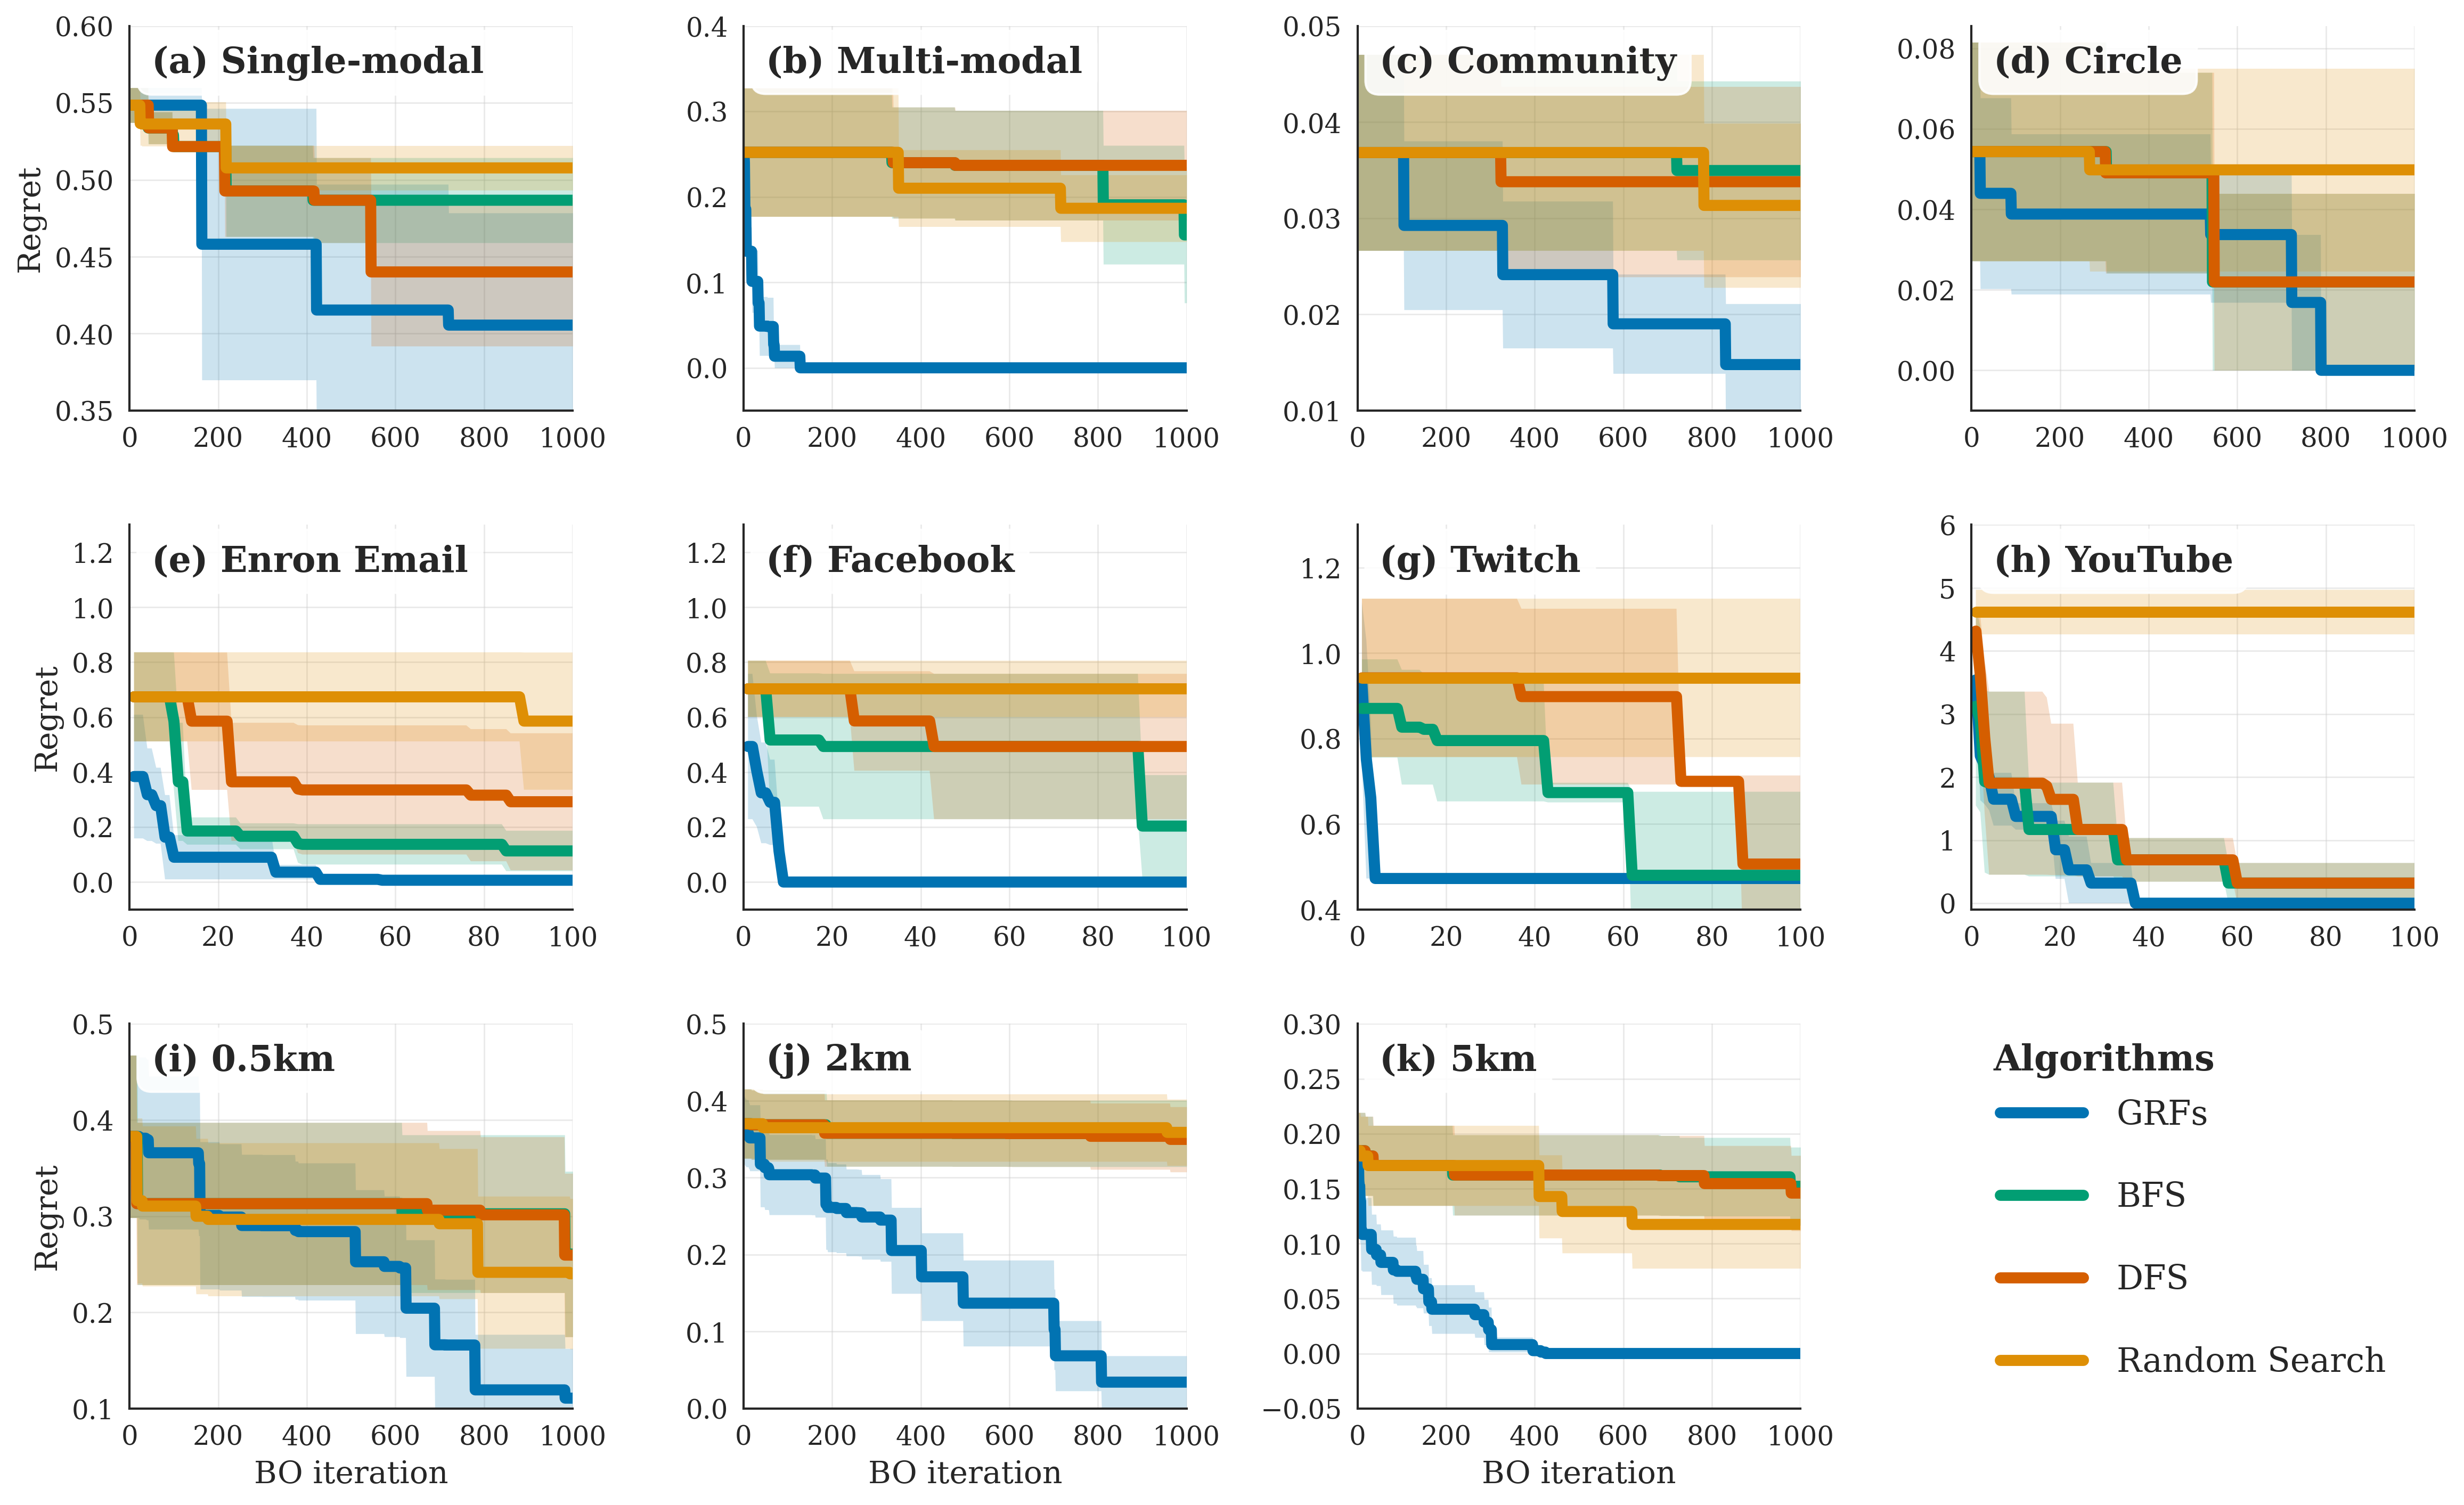

In [7]:
def create_combined_regret_plots(dataframes, figsize=(16, 10), line_width=3.0):
    """
    Create a 3x4 grid of regret plots for all datasets
    """
    # Set up the subplot arrangement with panel labels
    dataset_arrangement = [
        # Row 1: Synthetic graphs
        ['single-modal', 'multi-modal', 'community', 'circle'],
        # Row 2: Social networks
        ['enron', 'facebook', 'twitch', 'youtube'],
        # Row 3: Weather data + empty slot
        ['500hpa', '800hpa', '1000hpa', 'legend']
    ]
    
    # Panel labels for ICLR style
    panel_labels = [
        ['(a)', '(b)', '(c)', '(d)'],
        ['(e)', '(f)', '(g)', '(h)'],
        ['(i)', '(j)', '(k)', '']
    ]
    
    # Custom titles for better display
    plot_titles = {
        'single-modal': 'Single-modal',
        'multi-modal': 'Multi-modal',
        'community': 'Community',
        'circle': 'Circle',
        'enron': 'Enron Email',
        'facebook': 'Facebook',
        'twitch': 'Twitch', 
        'youtube': 'YouTube',
        '500hpa': '0.5km',
        '800hpa': '2km',
        '1000hpa': '5km'
    }
    
    # Configurable axis limits for each dataset
    axis_limits = {
        # Synthetic graphs
        'single-modal': {'x': (0, 1000), 'y': (0.35, 0.6), 'x_ticks': 200},
        'multi-modal': {'x': (0, 1000), 'y': (-0.05, 0.4), 'x_ticks': 200},
        'community': {'x': (0, 1000), 'y': (0.01, 0.05), 'x_ticks': 200},
        'circular': {'x': (0, 1000), 'y': (-0.05, 0.1), 'x_ticks': 200},

        # Social networks
        'facebook': {'x': (0, 100), 'y': (-0.1, 1.3), 'x_ticks': 20},
        'enron': {'x': (0, 100), 'y': (-0.1, 1.3), 'x_ticks': 20},
        'twitch': {'x': (0, 100), 'y': (0.4, 1.3), 'x_ticks': 20},
        'youtube': {'x': (0, 100), 'y': (-0.1, 6), 'x_ticks': 20},
        
        # Weather data
        '500hpa': {'x': (0, 1000), 'y': (0.1, 0.5), 'x_ticks': 200},
        '800hpa': {'x': (0, 1000), 'y': (0, 0.5), 'x_ticks': 200},
        '1000hpa': {'x': (0, 1000), 'y': (-0.05, 0.3), 'x_ticks': 200}
    }
    
    # Set global styling for ICLR publication
    mpl.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "font.family": "serif",  # Better font for publications
        "font.serif": ["Computer Modern Roman", "Latin Modern Roman", "DejaVu Serif"],
        "mathtext.fontset": "cm",  # Computer Modern math fonts (LaTeX style)
        "font.size": 14,  # Larger base font
        "axes.titlesize": 16,  # Larger titles
        "axes.labelsize": 14,  # Larger axis labels
        "xtick.labelsize": 12,  # Larger tick labels
        "ytick.labelsize": 12,
        "legend.fontsize": 13,  # Larger legend
        "axes.linewidth": 1.0,
        "grid.linewidth": 0.7,
        "grid.alpha": 0.4,
    })
    
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    
    # Color palette and styling
    palette = sns.color_palette("colorblind", n_colors=5)
    colors = {
        "sparse_grf": to_hex(palette[0]),
        "random_search": to_hex(palette[1]),
        "bfs": to_hex(palette[2]), 
        "dfs": to_hex(palette[3]),
        "thompson_sampling": to_hex(palette[4])
    }
    
    legend_names = {
        "random_search": "Random Search",
        "sparse_grf": "GRFs",
        "bfs": "BFS",
        "dfs": "DFS",
        "thompson_sampling": "Thompson Sampling"
    }
    
    lw = line_width  # Tunable line thickness
    legend_handles = []
    legend_labels = []
    
    # Plot each dataset
    for row in range(3):
        for col in range(4):
            ax = axes[row, col]
            dataset_name = dataset_arrangement[row][col]
            
            if dataset_name is None:
                ax.axis('off')
                continue
                
            if dataset_name == 'legend':
                # This will be the legend subplot
                ax.axis('off')
                continue
                
            if dataset_name not in dataframes:
                ax.axis('off')
                ax.text(0.5, 0.5, f'{dataset_name}\nNot Found', 
                       transform=ax.transAxes, ha='center', va='center')
                continue
                
            df = dataframes[dataset_name]
            
            # Get algorithms and sort them in the new order: GRFs -> BFS -> DFS -> Random Search
            present = [a for a in df["algorithm"].unique()]
            priority = {"sparse_grf": 0, "bfs": 1, "dfs": 2, "random_search": 3}
            algorithms = sorted(present, key=lambda a: (priority.get(a, 999), a))
            
            # Plot each algorithm
            for algo in algorithms:
                d = df[df["algorithm"] == algo]
                if len(d) == 0:
                    continue
                    
                color = colors.get(algo, "#000000")
                label = legend_names.get(algo, algo.replace("_", " ").title())
                
                if 'regret_mean' in d.columns:
                    # Summary format
                    iterations = d['iteration'].values
                    regret_mean = d['regret'].values
                    regret_std = d['regret_std'].values if 'regret_std' in d.columns else None
                    
                    # Convert std to standard error
                    if regret_std is not None:
                        n_seeds = d['best_value_count'].iloc[0] if 'best_value_count' in d.columns else 5
                        regret_std = regret_std / np.sqrt(n_seeds)
                    
                    line = ax.plot(iterations, regret_mean, linestyle="-", linewidth=lw, 
                                  color=color, label=label)[0]
                    
                    if regret_std is not None:
                        ax.fill_between(iterations, regret_mean - regret_std, regret_mean + regret_std,
                                      color=color, alpha=0.2, linewidth=0)
                else:
                    # Detailed format
                    if "iteration" not in d.columns or "regret" not in d.columns:
                        continue
                        
                    g = d.groupby("iteration")["regret"]
                    mean = g.mean().sort_index()
                    std = g.std().sort_index() 
                    n_seeds = len(d['bo_seed'].unique()) if 'bo_seed' in d.columns else 1
                    
                    # Convert std to standard error
                    if n_seeds > 1:
                        std_err = std / np.sqrt(n_seeds)
                    else:
                        std_err = std
                        
                    line = ax.plot(mean.index.values, mean.values, linestyle="-", linewidth=lw,
                                  color=color, label=label)[0]
                    
                    if n_seeds > 1 and not std_err.isna().all():
                        ax.fill_between(mean.index.values, (mean - std_err).values, (mean + std_err).values,
                                      color=color, alpha=0.2, linewidth=0)
                
                # Collect handles for legend (only once per algorithm)
                if label not in legend_labels:
                    legend_handles.append(line)
                    legend_labels.append(label)
            
            # Formatting for each subplot
            ax.grid(True, which="major", axis="both")
            for spine in ["top", "right"]:
                ax.spines[spine].set_visible(False)
            
            # Add combined panel label and title in top-left corner (ICLR style)
            panel_label = panel_labels[row][col]
            title = plot_titles.get(dataset_name, dataset_name.replace('_', ' ').title())
            if panel_label:
                combined_text = f"{panel_label} {title}"
                ax.text(0.05, 0.95, combined_text, transform=ax.transAxes, 
                       fontsize=16, fontweight='bold', va='top', ha='left',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
            
            # Set axis limits based on configuration
            if dataset_name in axis_limits:
                limits = axis_limits[dataset_name]
                ax.set_xlim(limits['x'])
                ax.set_ylim(limits['y'])
                ax.xaxis.set_major_locator(MultipleLocator(limits['x_ticks']))
            else:
                # Fallback to default behavior
                max_iter = df['iteration'].max()
                ax.set_xlim(0, min(max_iter + 5, 1000))
                ax.set_ylim(bottom=-0.01)
            
            # Labels only on outer edges
            if row == 2:  # Bottom row
                ax.set_xlabel("BO iteration")
            if col == 0:  # Left column
                ax.set_ylabel("Regret")
    
    # Add legend in bottom-right position (2,3)
    legend_ax = axes[2, 3]
    
    # Style the legend subplot like other plots
    legend_ax.grid(True, which="major", axis="both")
    for spine in ["top", "right"]:
        legend_ax.spines[spine].set_visible(False)
    
    # Remove ticks and labels but keep the frame
    legend_ax.set_xticks([])
    legend_ax.set_yticks([])
    legend_ax.set_xlim(0, 1)
    legend_ax.set_ylim(0, 1)
    
    # Add "Algorithms" label inside the subplot (top-left corner)
    legend_ax.text(0.05, 0.95, 'Algorithms', transform=legend_ax.transAxes, 
                   fontsize=16, fontweight='bold', va='top', ha='left',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
    
    # Create larger legend with collected handles and labels (positioned lower)
    legend = legend_ax.legend(legend_handles, legend_labels, 
                            loc='lower center', frameon=False, fontsize=15,
                            handlelength=2.5, handletextpad=1.0, 
                            columnspacing=1.2, labelspacing=1.5,
                            markerscale=1.2)
    
    # Make legend lines thicker to match plot lines
    for line in legend.get_lines():
        line.set_linewidth(lw)
    
    # Remove axis content but keep the styled frame
    legend_ax.patch.set_facecolor('white')
    legend_ax.patch.set_alpha(1.0)
    
    plt.tight_layout(pad=2.0)
    plt.show()
    return fig, axes

# Create the combined plot
sns.set_style("white")
print("📈 Creating combined 3x4 regret plots...")
combined_fig, combined_axes = create_combined_regret_plots(dataframes, line_width=5)